In [94]:
import ndlib
import networkx as nx
import ndlib.models.epidemics as ep
import json
import ndlib.models.ModelConfig as mc
import numpy as np
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
import tkinter


from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

## Gillespie's direct algorithm ##
From the site of the book


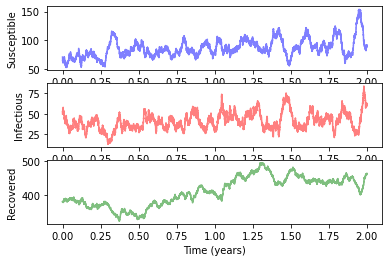

In [29]:
####################################################################
###    This is the PYTHON version of program 6.4 from page 203 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR model (including births and deaths) with full    #
### (event-driven) demographic stochasticity.					   #
###																   #
### This is a more complex stochastic model as 6 events are		   #
### possible: infection, recovery, birth, death of susceptible,    #
### death of infected, death of recovered.					       #
### Note: by default we are using a very small population size 	   #
### to highlight the stochasticity.				   				   #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import numpy as np
import pylab as pl

beta=1.0
gamma=1/7.0
mu=1/70
N0=500
# delta = math.sqrt(N0)*5.5e-03
delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)
### You may want to try with popylation size of 50 (small) to see the events
### In this case uncomment the next line
#N0=50.0
ND=MaxTime=2*365.0
Y0=pl.ceil(mu*N0/gamma)
X0=pl.floor(gamma*N0/beta)
# Y0=5
# X0=8000
Z0=N0-X0-Y0

INPUT = np.array((X0,Y0,Z0))

timestep=0.0

def stoc_eqs(INP,ts): 
	V = INP
	Rate=np.zeros((7))
	Change=np.zeros((7,3))
	N=np.sum(V[range(3)])
	Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0]);
	Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1]);
	Rate[2] = mu*N;  Change[2,:]=([+1, 0, 0]);
	Rate[3] = mu*V[0];  Change[3,:]=([-1, 0, 0]);
	Rate[4] = mu*V[1];  Change[4,:]=([0, -1, 0]);
	Rate[5] = mu*V[2];  Change[5,:]=([0, 0, -1]);
	Rate[6] = delta;  Change[6,:]=([0, +1, 0]);
	R1=pl.rand();
	R2=pl.rand();
	ts = -np.log(R2)/(np.sum(Rate));
	list1 = np.cumsum(Rate)
	for i in range(len(list1)):
		if list1[i] >= R1*np.sum(Rate):
			V[range(3)] = V[range(3)]+Change[i,:]
			return [V,ts]


def Stoch_Iteration(INPUT):
	lop=0
	ts=0
	T=[0]
	S=[0]
	I=[0]
	R=[0]
	while T[lop] < ND:
		lop=lop+1
		T.append(T[lop-1]+ts)
		S.append(INPUT[0])
		I.append(INPUT[1])
		R.append(INPUT[2])
		[res,ts] = stoc_eqs(INPUT,ts)
		lop=lop+1
		T.append(T[lop-1])
		S.append(INPUT[0])
		I.append(INPUT[1])
		R.append(INPUT[2])
	return [T,S,I,R]

[T,S,I,R]=Stoch_Iteration(INPUT)

tT=np.array(T)[1:,]/365.
tS=np.array(S)[1:,]
tI=np.array(I)[1:,]
tR=np.array(R)[1:,]

pl.subplot(311)
pl.plot(tT, tS, 'b', alpha=0.5)
#pl.xlabel ('Time (years)')
pl.ylabel ('Susceptible')
pl.subplot(312)
pl.plot(tT, tI, 'r', alpha=0.5)
#pl.xlabel ('Time (years)')
pl.ylabel ('Infectious')
pl.subplot(313)
pl.plot(tT, tR, 'g', alpha=0.5)
pl.xlabel ('Time (years)')
pl.ylabel ('Recovered')
pl.show()

TypeError: __init__() got an unexpected keyword argument 'bbox_to_ancher'

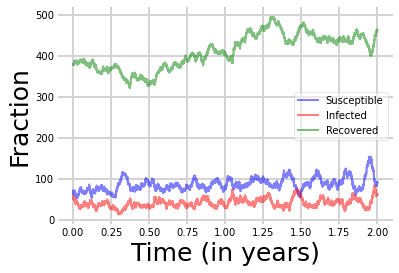

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(tT, tS, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(tT, tI, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(tT, tR, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time (in years)', size = 25)
ax.set_ylabel('Fraction', size = 25)
# ax.set_ylim(0,2)
# ax.set_xlim(0,2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='lightgray', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.legend(fontsize="large")
plt.show()

## SIR Metapopulation model for humans
From the site of the book

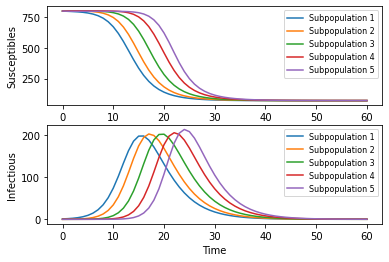

In [106]:
#!/usr/bin/env python

####################################################################
###    This is the PYTHON version of program 7.2 from page 242 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR epidemic in a metapopulationFor simplicity births#
### and deaths have been ignored, and we work with numbers of      #
### individuals.                                                   #
### Y[i][j] refers to infected individual who are currently in i   #
### but live in j..                                                #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import scipy.integrate as spi
import numpy as np
import pylab as pl
from matplotlib.font_manager import FontProperties as fmp

n=5
beta=1*np.ones(n);
gamma=0.3*np.ones(n);
N0=np.zeros(n*n);
X0=np.zeros(n*n);
for i in np.arange(0,n*n,n+1):
	N0[i]=1000.0
	X0[i]=800.0

Y0=np.zeros(n*n); Y0[0]=1.0;
ND=MaxTime=60.
TS=1.0

l=np.zeros((n,n));r=np.zeros((n,n))
for i in range(n):
	for j in range(n):
		if abs(i-j)==1: 
			l[i][j]=0.1
r=2*np.ones((n,n)); r=r-np.diag(np.diag(r));
# print(r)

INPUT0=np.hstack((X0,Y0,N0))
INPUT = np.zeros((3*n*n))
for i in range(n*n):
	INPUT[3*i]=INPUT0[i]
	INPUT[1+3*i]=INPUT0[n*n+i]
	INPUT[2+3*i]=INPUT0[2*n*n+i]

# print(INPUT0)
# print(INPUT)

def diff_eqs(INP,t):  
	'''The main set of equations'''
	Y=np.zeros((3*n*n))
	V = INP   
	sumY=np.zeros(n)
	sumN=np.zeros(n)
	
	## Calculate number currently in Subpopulation i
	for i in range(n):
		sumY[i]=0.0;sumN[i]=0.0
		for j in range(n):
			k=3*(j+i*n);
			sumN[i]+=V[2+k];
			sumY[i]+=V[1+k];	
			
# 	print(sumY)

	## Set all rates to zeros
	for i in range(n):
		for j in range(n):
			k=3*(j+i*n);
			Y[k]=0; Y[1+k]=0; Y[2+k]=0

	for i in range(n):
		for j in range(n):		
			## Calculate the rates
			k = 3 * (j+i*n) 
			K = 3 * (i+j*n)
			h = 3 * (i+i*n)
			H = 3 * (j+j*n)
			
			Y[k] -= (beta[i]*V[k]*(sumY[i]/sumN[i]))
			Y[k+1] += (beta[i]*V[k]*(sumY[i]/sumN[i]))
			Y[k+1] -= (gamma[i]*V[k+1])
# 			print(Y)          
			
			## Movement
			Y[h] += r[j][i]*V[K]
			Y[h] -= l[j][i]*V[h]
			
			Y[h+1] += r[j][i]*V[K+1]
			Y[h+1] -= l[j][i]*V[h+1]
			
			Y[h+2] += r[j][i]*V[K+2]
			Y[h+2] -= l[j][i]*V[h+2]
			
			Y[k] += l[i][j]*V[H]
			Y[k] -= r[i][j]*V[k]
			
			Y[1+k] += l[i][j]*V[1+H]
			Y[1+k] -= r[i][j]*V[1+k]
			
			Y[2+k] += l[i][j]*V[2+H]
			Y[2+k] -= r[i][j]*V[2+k]
# 	print(Y)
	return Y   # For odeint

t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
t_course = spi.odeint(diff_eqs,INPUT,t_range)
# print(t_course[1])
tc = t_course

### Plotting
totalS=np.zeros((len(tc),n))
totalI=np.zeros((len(tc),n))

for i in range(n):
	for j in range(n):
		k=3*(j+i*n);
		totalS[:,i]+=tc[:,k]
		totalI[:,i]+=tc[:,k+1]


#print len(totalS)
plt.subplot(211)
for i in range(n):
	plt.plot(t_range,totalS[:,i], label=('Subpopulation %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Susceptibles')
plt.legend(loc = "upper right", fontsize = 8)
plt.subplot(212)
for i in range(n):
	plt.plot(t_range,totalI[:,i], label=('Subpopulation %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Infectious')
plt.legend(loc = "upper right", fontsize = 8)

plt.show()